<a href="https://colab.research.google.com/github/outsider8946/cat_breed_recognizer/blob/main/model/train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split

In [2]:
PATH_TO_DATA = '/content/drive/MyDrive/Colab Notebooks/cat_breed_recognizer/data/'
cat_breeds = ['bengal', 'maine_coon', 'ragdoll', 'oriental_shorthair', 'british_shorthair','siamese']

In [3]:
dev = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device =  torch.device(dev)
dev

'cuda:0'

In [4]:
X = []
y = []
for breed in cat_breeds:
  print(breed)
  if os.path.exists(PATH_TO_DATA+breed+f'/{breed}.csv'):
    df = pd.read_csv(PATH_TO_DATA+breed+f'/{breed}.csv',on_bad_lines='skip')
    for i in range(len(df)):
      img_name = df.loc[i,'image_name']
      img_mat = cv2.imread(PATH_TO_DATA+breed+f'/{img_name}')
      img_mat = cv2.resize(img_mat,(32,32))
      img_mat= img_mat/255
      X.append(img_mat)
      y.append(df.loc[i, ['label_name','norm_bbox_x', 'norm_bbox_y', 'norm_bbox_width', 'norm_bbox_height','image_width','image_height']].to_numpy().tolist())
X = np.array(X)
y = np.array(y)
X.shape, y.shape

bengal
maine_coon
ragdoll
oriental_shorthair
british_shorthair
siamese


((1155, 32, 32, 3), (1155, 7))

In [ ]:
X = np.load(PATH_TO_DATA+'X.npy')
y = np.load(PATH_TO_DATA+'y.npy')

<Axes: ylabel='Count'>

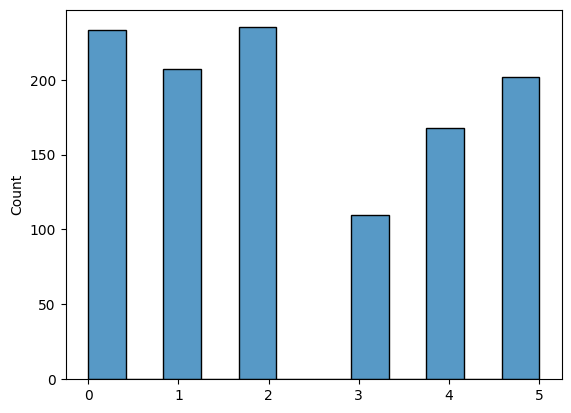

In [5]:
sns.histplot(data=y[:,0])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=True,random_state=42)

X_train = torch.tensor(X_train).float().to(device)
y_train = torch.tensor(y_train).float().to(device)
X_test = torch.tensor(X_test).float().to(device)
y_test = torch.tensor(y_test).float().to(device)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([866, 32, 32, 3]),
 torch.Size([866, 7]),
 torch.Size([289, 32, 32, 3]),
 torch.Size([289, 7]))

In [7]:
class CatDataset(Dataset):
  def __init__(self,X,y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self,i):
    return self.X[i], self.y[i]

train_dataset = CatDataset(X_train,y_train)
test_dataset = CatDataset(X_test,y_test)

In [8]:
batch_size = 32
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

In [52]:
class CatModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.regressor = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2)),
        nn.Dropout(0.3),

        nn.Conv2d(32,32,kernel_size=(3,3),stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2)),
        nn.Flatten(),

        nn.Linear(8*8*32, 8*32),
        nn.ReLU(),

        nn.Linear(8*32, 4*32),
        nn.ReLU(),

        nn.Linear(4*32, 32),
        nn.ReLU(),

        nn.Linear(32, 4),
     )

    self.classifier = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size=(2, 2)),
        nn.Dropout(0.3),

        nn.Conv2d(32,32,kernel_size=(3,3),stride=1,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size=(2, 2)),
        nn.Flatten(),

        nn.Linear(8*8*32, 4*32),
        nn.ReLU(),

        nn.Linear(4*32, 32),
        nn.ReLU(),

        nn.Linear(32, 6),
        nn.Softmax()
      )

  def forward(self,x):
    # reshape
    x = x.view(x.shape[0], 3, 32,32)
    return self.regressor(x), self.classifier(x)


In [53]:
model = CatModel()
model.to(device)
bbox_loss = nn.MSELoss()
label_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 300
for epoch in range(n_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        input, targets = data[0].to(device), data[1].to(device)

        #convert targets to correct dimension
        labels = np.array([[0]*6]*targets.shape[0],dtype=np.float64)
        for batch in range(targets.shape[0]):
          labels[batch,int(targets[batch,0].cpu())] = 1
        labels = torch.tensor(labels).float().to(device)
        bounds = targets[:,1:4+1]
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = model(input)
        regressor_loss = bbox_loss(output[0], bounds)

        classifier_loss = label_loss(output[1],labels)
        total_loss = classifier_loss + regressor_loss

        #total_loss.backward()
        total_loss.backward()
        optimizer.step()

        # print statistics
        running_loss += total_loss.item()

        if i % 10 == 9:    # print every 10 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] running loss:{running_loss:.5f},  box loss: {regressor_loss:.5f}, class loss:{classifier_loss:.5f}')
            running_loss = 0.0

print('Finished Training')

[1,    10] running loss:18.82077,  box loss: 0.04584, class loss:1.74617
[1,    20] running loss:17.81545,  box loss: 0.04191, class loss:1.70450
[2,    10] running loss:17.06927,  box loss: 0.03997, class loss:1.47088
[2,    20] running loss:17.24190,  box loss: 0.03187, class loss:1.72719
[3,    10] running loss:16.95101,  box loss: 0.04036, class loss:1.67056
[3,    20] running loss:16.95713,  box loss: 0.03525, class loss:1.77414
[4,    10] running loss:16.24142,  box loss: 0.03205, class loss:1.59181
[4,    20] running loss:16.47968,  box loss: 0.03464, class loss:1.59514
[5,    10] running loss:16.08708,  box loss: 0.02505, class loss:1.53764
[5,    20] running loss:15.84888,  box loss: 0.02509, class loss:1.56156
[6,    10] running loss:15.60624,  box loss: 0.02892, class loss:1.44890
[6,    20] running loss:15.80618,  box loss: 0.02688, class loss:1.69468
[7,    10] running loss:15.07882,  box loss: 0.03387, class loss:1.44924
[7,    20] running loss:15.16236,  box loss: 0.0383

In [54]:
model.eval()

CatModel(
  (regressor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=2048, out_features=256, bias=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=128, bias=True)
    (11): ReLU()
    (12): Linear(in_features=128, out_features=32, bias=True)
    (13): ReLU()
    (14): Linear(in_features=32, out_features=4, bias=True)
  )
  (classifier): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [38]:
def IOU(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

In [33]:
def get_box(y_test,width,height):
   box_width, box_height = y_test[2]*width, y_test[3]*height
   x0,y0 = y_test[0]*width, y_test[1]*height
   x1, y1 = x0 + box_width, y0 + box_height
   return [x0,y0,x1,y1]

# **Accruacy of prediciton boundaries by IOU metric**

In [55]:
bound_accuracy, label_accuracy = 0, 0
size = 0
with torch.no_grad():
  for i, data in enumerate(test_dataloader, 0):
    X_test,y_test = data[0].to(device), data[1].to(device)
    out = model(X_test)
    for batch in range(y_test.shape[0]):
      width,height = y_test[batch,5], y_test[batch,6]
      actual_box = get_box(y_test[batch,1:4+1],width,height)
      bound_pred, label_pred = out[0][batch],out[1][batch]
      bound_pred = bound_pred.cpu().numpy()
      label_pred = label_pred.cpu().numpy().argmax()
      pred_box = get_box(bound_pred,width,height)
      bound_accuracy+=IOU(actual_box,pred_box)
      label_accuracy+= 1 if label_pred == y_test[batch,0] else 0
      size+=1
bound_accuracy /= size
label_accuracy /=size
print('IOU: ',float(bound_accuracy))
print('Class accuracy: ',label_accuracy)

IOU:  0.5015634894371033
Class accuracy:  0.42214532871972316


In [56]:
RUNING_LOSS = 10.77457
CLASS_LOSS = 1.07488
BOX_LOSS = 0.00540
EPOCH = 300
PATH = '/content/drive/MyDrive/Colab Notebooks/cat_breed_recognizer/cat_breed_classifier_v3.pt'

torch.save({
    'epoch':EPOCH,
    'class_loss':CLASS_LOSS,
    'box_loss':BOX_LOSS,
    'loss':RUNING_LOSS,
    'model_state_dict':model.state_dict(),
    'optimizer_state_dict':optimizer.state_dict()
},PATH)


In [ ]:
np.save(PATH_TO_DATA+'X.npy',X)
np.save(PATH_TO_DATA+'y.npy',y)